# Маркетинговый анализ приложения Procrastinate Pro+

Необходимо провести маркетинговый анализ развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
    
 - лог сервера с данными об их посещениях,
 - выгрузка их покупок за этот период,
 - рекламные расходы.

**Цели и задачи проекта:**

 - загрызить данные и выполнить предобработку;
 - задать функции для расчёта и анализа LTV, ROI, удержания и конверсии;
 - составить профили пользователей;
 - выяснить, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей;
 - узнать, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи;
 - изучить рекламные источники привлечения и определить каналы, из которых пришло больше всего платящих пользователей;
 - посчитать общую сумму расходов на маркетинг;
 - выяснить, как траты распределены по рекламным источникам;
 - изучить динамику изменения расходов во времени по неделям по каждому источнику;
 - выяснить, сколько в среднем стоило привлечение одного пользователя из каждого источника;
 - проанализировать окупаемость рекламы;
 - проверить конверсию пользователей и динамику её изменения;
 - проанализировать окупаемость рекламы с разбивкой по устройствам, странам и рекламным каналам;
 - выделить причины неэффективности привлечения пользователей;
 - сформулировать рекомендации для отдела маркетинга.

### Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

Загружаем данные о визитах, заказах и рекламных расходах:

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

Добавила цикл для подсчета дубликатов в таблицах:

In [3]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [4]:
for df in [visits, orders, costs]:
    a = df.duplicated().sum()
    if a > 0:
        print(f'Количество дубликатов в таблице: {a}')
    else:
        print(f'В таблице  {get_df_name(df)} нет дубликатов')

В таблице  visits нет дубликатов
В таблице  orders нет дубликатов
В таблице  costs нет дубликатов


*Общая информация данных о визитах:*

In [5]:
def processing(df):
    if df.duplicated().sum() > 0:
        df.drop_duplicates(inplace=True)
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    return df.info()

In [6]:
processing(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Фрейм с данными о визитах содержит 309901 строку и 6 столбцов:
 - User Id — уникальный идентификатор пользователя,
 - Region — страна пользователя,
 - Device — тип устройства пользователя,
 - Channel — идентификатор источника перехода,
 - Session Start — дата и время начала сессии,
 - Session End — дата и время окончания сессии.

Из общей информации видно, что пропущенных значений нет. Столбцы Session Start и Session End имеют некорректный тип.

*Общая информация данных с заказами:*

In [7]:
processing(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Фрейм с данными о заказах содержит 40212 строку и 3 столбца:
 - User Id — уникальный идентификатор пользователя,
 - Event Dt — дата и время покупки,
 - Revenue — сумма заказа.

Из общей информации видно, что пропущенных значений нет. Столбец Event Dt имеет некорректный тип.

*Общая информация данных с расходами:*

In [8]:
processing(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Фрейм с данными о расходах содержит 1800 строк и 3 столбца:
 - dt — дата проведения рекламной кампании,
 - Channel — идентификатор рекламного источника,
 - costs — расходы на эту кампанию.

Из общей информации видно, что пропущенных значений нет. Столбец dt имеет некорректный тип.

Приведем даты во всех фреймах к корректному типу:

In [9]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [10]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [11]:
costs['dt'] = pd.to_datetime(costs['dt'])

В ходе предобработки данных:
 - Привели названия всех столбцов к нижнему регистру;
 - Сделали проверку на наличие явных дубликатов - явных дубликатов не обнаружено;
 - Привели все столбцы с датами к кореектному типу datetime;
 - Пропусков во всех фреймах данных не обнаружено.

Проверка на наличие неявных дубликатов:

In [12]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

In [13]:
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [14]:
visits['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

В ходе проверки неявных дубликатов не обнаружено.

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

Функция для создания пользовательских профилей:

In [15]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].values.astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    new_users['dt'] = pd.to_datetime(new_users['dt'])
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    profiles['dt'] = pd.to_datetime(profiles['dt'])
    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Функция для расчёта удержания:

In [16]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Функция для расчёта конверсии:

In [17]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Функция для расчёта LTV и ROI:

In [18]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

Функция для сглаживания фрейма:

In [19]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

Функция для визуализации удержания:

In [20]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

Функция для визуализации конверсии:

In [21]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Функция для визуализации LTV и ROI:

In [22]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

**Профили пользователей**

In [23]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


*Минимальная дата привлечения пользователей:*

In [24]:
profiles['dt'].min()

Timestamp('2019-05-01 00:00:00')

*Максимальная дата привлечения пользователей:*

In [25]:
profiles['dt'].max()

Timestamp('2019-10-27 00:00:00')

Нашли минимальную и максимальную дату привлечения пользователей. Они соответствуют датам в описании проекта.

**Страны пользователей приложения**

In [26]:
def info_table(parametr):
    users_by_parametr = profiles.pivot_table(index=parametr, values=['user_id'], aggfunc={'count'})
    users_by_parametr.columns =['user_count']
    users_by_parametr['share_of_payer'] = round(profiles.groupby(parametr).agg({'payer': 'mean'}) * 100, 2)
    return users_by_parametr.sort_values(by='share_of_payer', ascending=False)

In [27]:
info_table('region')

,user_count,share_of_payer
region,,
United States,100002,6.90
Germany,14981,4.11
UK,17575,3.98
France,17450,3.80


In [28]:
users_by_region = profiles.pivot_table(index=['region'], values=['user_id'], aggfunc={'count'})

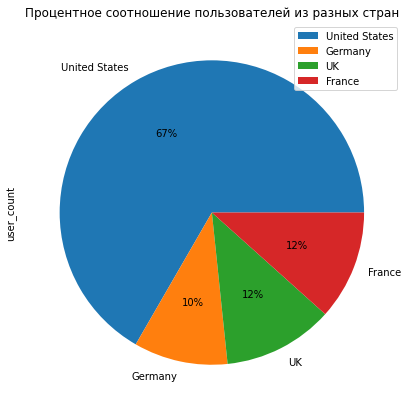

In [29]:
info_table('region').plot(y='user_count', kind='pie', figsize=(7, 7), autopct = '%1.0f%%', title = 'Процентное соотношение пользователей из разных стран');

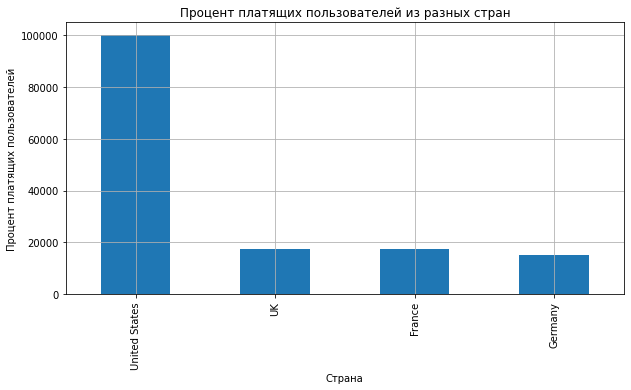

In [30]:
info_table('region')['user_count'].sort_values(ascending=False).plot.bar(figsize=(10, 5), grid=True)
plt.title('Процент платящих пользователей из разных стран');
plt.xlabel('Страна');
plt.ylabel('Процент платящих пользователей');
plt.show()

Пользователи данного приложения из четырех стран: США, Германия, Великобритания и Франция. Наибольшее количество пользователей из США (67%), что значительно выше, чем количество пользователей из других стран - Франция, Великобритания (12%) и Генрмания (10%). Среди платящих пользователей также наибольший процент из США (6.9%), далее идет Германия (4.11%), Великобритания (3.98), наименьший процент платящих пользователей из Франции (3.8%).

**Устройства пользователей приложения**

In [31]:
info_table('device')

,user_count,share_of_payer
device,,
Mac,30042,6.36
iPhone,54479,6.21
Android,35032,5.85
PC,30455,5.05


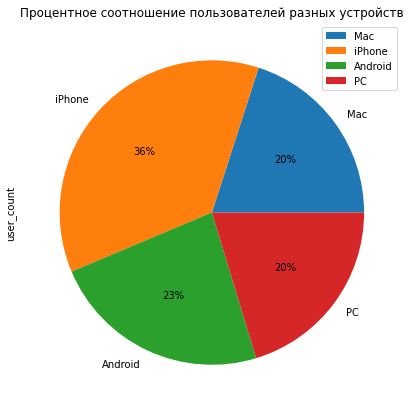

In [32]:
info_table('device').plot(y='user_count', kind='pie', figsize=(7, 7), autopct = '%1.0f%%', title = 'Процентное соотношение пользователей разных устройств');

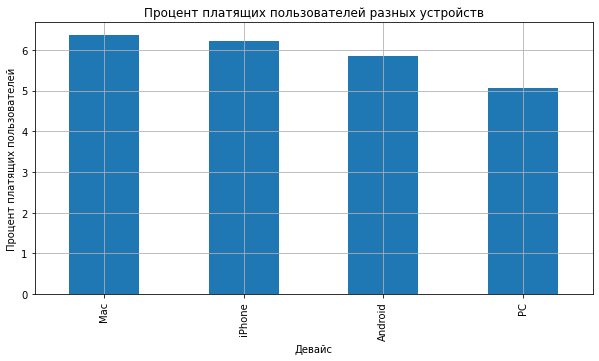

In [33]:
info_table('device')['share_of_payer'].sort_values(ascending=False).plot.bar(figsize=(10, 5), grid=True)
plt.title('Процент платящих пользователей разных устройств');
plt.xlabel('Девайс');
plt.ylabel('Процент платящих пользователей');
plt.show()

Пользователи приложения используют следующие устройства: Mac, iPhone, Android, PC. Наибольшее количество пользователей использует iPhone (36%), далее идет Android (23%), количество пользователей, использующих Mac и PC примерно на одном уровне (20%). Наибольший процент платящих пользователей использует Mac (6.36%), чуть меньше платящих пользователей используют iPhone (6.21%), далее идет Android (5.85%) и PC (5.05%).

**Рекламные источники привлечения пользователей**

In [34]:
info_table('channel')

,user_count,share_of_payer
channel,,
FaceBoom,29144,12.20
AdNonSense,3880,11.34
lambdaMediaAds,2149,10.47
TipTop,19561,9.60
RocketSuperAds,4448,7.91
WahooNetBanner,8553,5.30
YRabbit,4312,3.83
MediaTornado,4364,3.57
LeapBob,8553,3.06


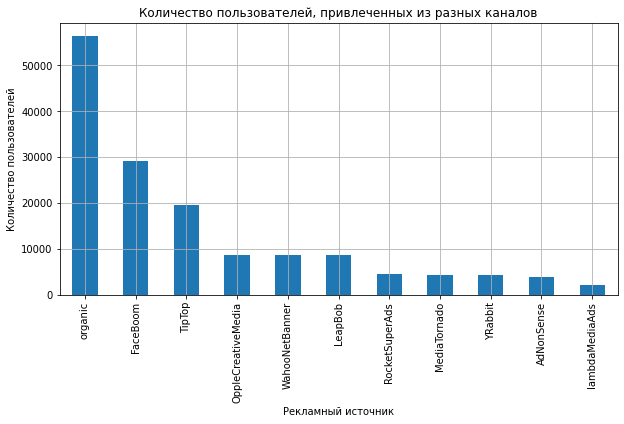

In [35]:
info_table('channel')['user_count'].sort_values(ascending=False).plot.bar(figsize=(10, 5), grid=True)
plt.title('Количество пользователей, привлеченных из разных каналов');
plt.xlabel('Рекламный источник');
plt.ylabel('Количество пользователей');
plt.show()

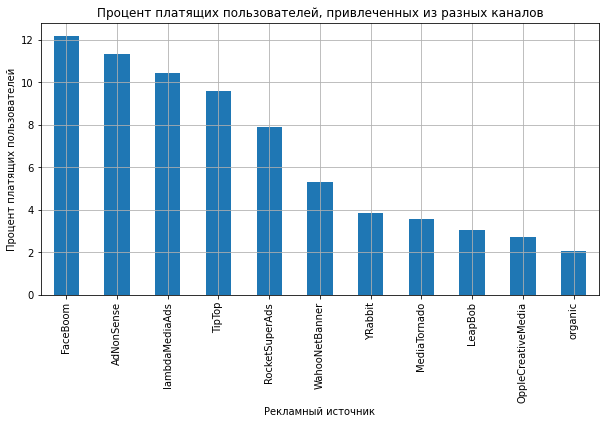

In [36]:
info_table('channel')['share_of_payer'].sort_values(ascending=False).plot.bar(figsize=(10, 5), grid=True)
plt.title('Процент платящих пользователей, привлеченных из разных каналов');
plt.xlabel('Рекламный источник');
plt.ylabel('Процент платящих пользователей');
plt.show()

Наибольшее количество пользователей привлечено из "органических" источников (56439 чел.), далее идет "FaceBoom" (29144 чел.) и "TipTop" (19561 чел.). Наибольший процент платящих пользователей привлечен из "FaceBoom" (12.2%), "AdNonSense" (11.34%) и "lambdaMediaAds" (10.47%). Наименьший процент платящих пользователей привлечено из "органических" источников (2.06%).

Составили профили пользователей, привлеченных с 1 мая 2019 года по 27 октября 2019 года:
 - Пользователи приложения из четырех стран: США, Германия, Великобритания и Франция. Наибольшее количество пользователей из США, среди платящих пользователей также наибольший процент из США (6.9%);
 - Пользователи приложения используют следующие устройства: Mac, iPhone, Android, PC. Наибольшее количество пользователей использует iPhone, наибольший процент платящих пользователей использует Mac (6.36%);
 - Наибольшее количество пользователей привлечено из "органических" источников, "FaceBoom" и "TipTop", Наибольший процент платящих пользователей привлечен из "FaceBoom" (12.2%), "AdNonSense" (11.34%) и "lambdaMediaAds" (10.47%).

### Маркетинг

Общая сумма расходов на маркетинг:

In [37]:
round(costs['costs'].sum())

105497

**Распределение трат по рекламным источникам:**

In [38]:
costs_by_channel = costs.pivot_table(index=['channel'], values=['costs'], aggfunc={'sum'})
costs_by_channel.columns =['sum_costs']
costs_by_channel['share_costs'] = round(((costs.groupby('channel')['costs'].sum()) / costs['costs'].sum()) * 100, 2)
costs_by_channel.sort_values(by='sum_costs', ascending=False).reset_index()

,channel,sum_costs,share_costs
0,TipTop,54751.30,51.90
1,FaceBoom,32445.60,30.75
2,WahooNetBanner,5151.00,4.88
3,AdNonSense,3911.25,3.71
4,OppleCreativeMedia,2151.25,2.04
5,RocketSuperAds,1833.00,1.74
6,LeapBob,1797.60,1.70
7,lambdaMediaAds,1557.60,1.48
8,MediaTornado,954.48,0.90
9,YRabbit,944.22,0.90


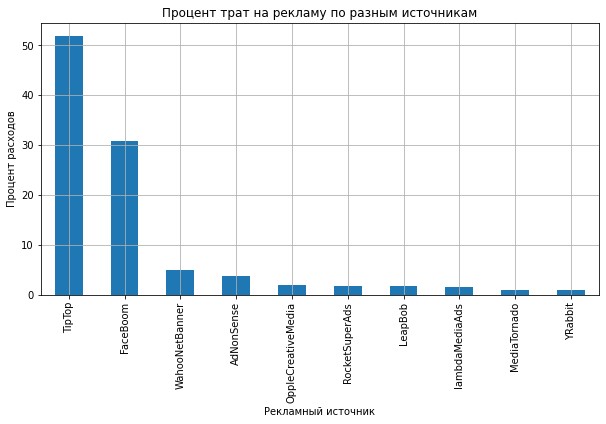

In [39]:
costs_by_channel['share_costs'].sort_values(ascending=False).plot.bar(figsize=(10, 5), grid=True)
plt.title('Процент трат на рекламу по разным источникам');
plt.xlabel('Рекламный источник');
plt.ylabel('Процент расходов');
plt.show()

Наибольшие траты на рекламу приходятся на источник "TipTop" (это 51.9% от общей суммы расходов на рекламу), далее идет "FaceBoom" (30.75%). Данные источники составляют больше 80% от всех расходов на рекламу и являются самыми дорогими. Далеее идет источник "WahooNetBanner" (4.88%). Меньше всего расходов приходится на источники "MediaTornado" и "YRabbit" (0.9%).

**Динамика изменения расходов на рекламу во времени по разным источникам:**

In [40]:
costs['n_month'] = costs['dt'].dt.month
costs['n_week'] = costs['dt'].dt.isocalendar().week
costs['f_costs'] = costs['costs'].rolling(window=5).mean()
costs_dynamics_week = costs.pivot_table(index=['channel', 'n_week'], values=['f_costs'], aggfunc={'sum'})
costs_dynamics_week.columns =['f_costs_sum']

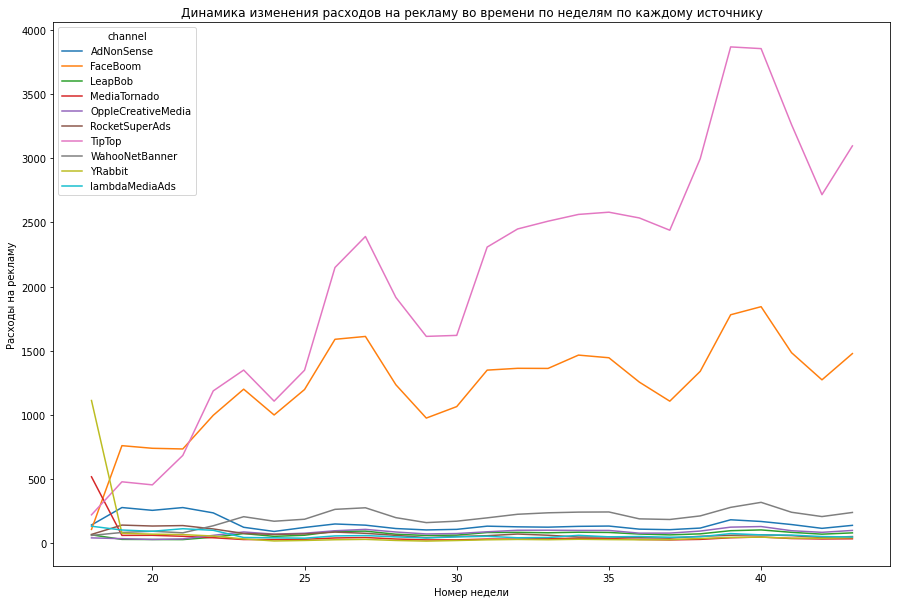

In [41]:
plt.figure(figsize=(15, 10))
sns.lineplot(x='n_week',y='f_costs_sum', hue='channel', data=costs_dynamics_week.reset_index()).set (title='Динамика изменения расходов на рекламу во времени по неделям по каждому источнику');
plt.xlabel('Номер недели');
plt.ylabel('Расходы на рекламу');

In [42]:
costs_dynamics_month = costs.pivot_table(index=['channel', 'n_month'], values=['costs'], aggfunc={'sum'})
costs_dynamics_month.columns =['costs_sum']

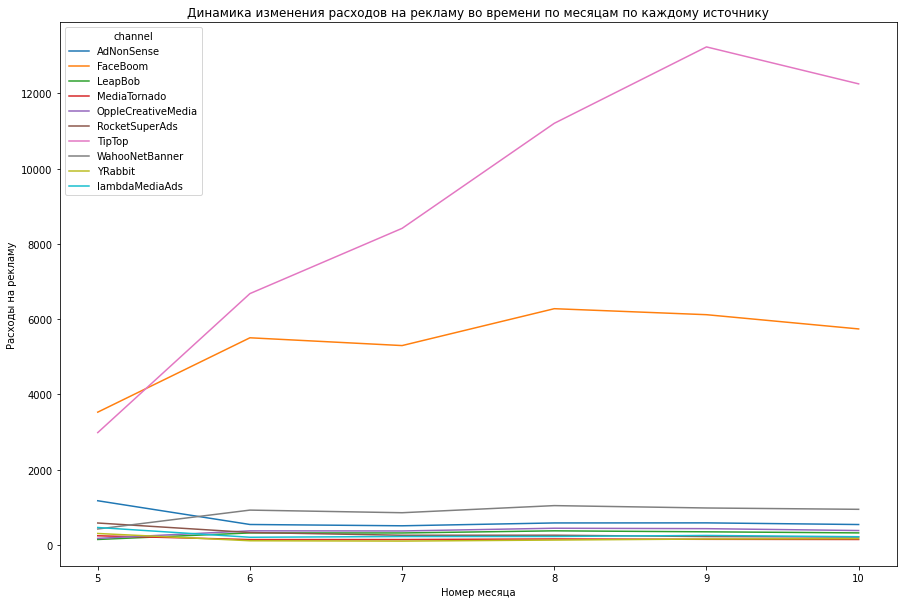

In [43]:
plt.figure(figsize=(15, 10))
sns.lineplot(x='n_month',y='costs_sum', hue='channel', data=costs_dynamics_month.reset_index()).set (title='Динамика изменения расходов на рекламу во времени по месяцам по каждому источнику');
plt.xlabel('Номер месяца');
plt.ylabel('Расходы на рекламу');

Изучив полученные графики, можно сделать вывод, что существенные изменения расходов на рекламу у источника "TipTop". График по неделям более детально отражает картину. По каналу "TipTop" наблюдается рост расходов, по недельному графику видно, что рост идет ступенчато, сопровождаясь периодическими незначительными спадами расходов. У источника "FaceBoom" наблюдается небольшой рост расходов на рекламу за изучаемый период. Кривые по остальным источникам сливаются. За весь период изменения в расходах по ним незначительны, но также можно наблюдать их волнообразный характер.

**Средняя стоимость привлечения одного пользователя из каждого источника:**

In [44]:
prof_without_org = profiles.query('channel != "organic"')
cac_by_channel = round(prof_without_org.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean'), 2)
cac_by_channel.columns =['cac']
cac_by_channel.sort_values(by='cac', ascending=False).reset_index()

,channel,cac
0,TipTop,2.80
1,FaceBoom,1.11
2,AdNonSense,1.01
3,lambdaMediaAds,0.72
4,WahooNetBanner,0.60
5,RocketSuperAds,0.41
6,OppleCreativeMedia,0.25
7,MediaTornado,0.22
8,YRabbit,0.22
9,LeapBob,0.21


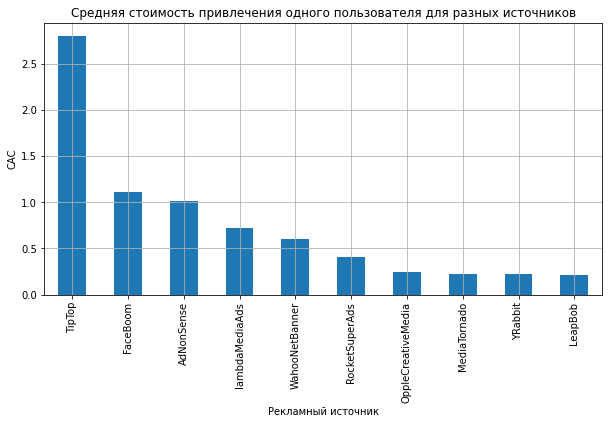

In [45]:
cac_by_channel['cac'].sort_values(ascending=False).plot.bar(figsize=(10, 5), grid=True)
plt.title('Средняя стоимость привлечения одного пользователя для разных источников');
plt.xlabel('Рекламный источник');
plt.ylabel('CAC');
plt.show()

Средняя стоимость привлечения одного клиента по всем каналам:

In [46]:
round(profiles['acquisition_cost'].mean(), 2)

0.7

Наиболее дорогой источник привлечения пользователя "TipTop" (2.8), по стоимости он сильно превосходит все остальные источники. Далее идут "FaceBoom"(1.1) и "AdNonSense" (1.0). Самым недорогим источником привлечения пользователя является "LeapBob" (0.21). В среденем, по всем каналам, на привлечение одного пользователя тратится 0.7.

Общая сумма расходов на маркетинг составила 105497. Наибольшие траты на рекламу приходятся на источник "TipTop" и "FaceBoom". Данные источники составляют больше 80% от всех расходов на рекламу и являются самыми дорогими. Меньше всего расходов приходится на источники "MediaTornado" и "YRabbit". Изучив динамику изменения расходов на рекламу, можно сделать вывод, что существенные изменения расходов на рекламу у источника "TipTop". Наблюдается ступенчатый рост расходов по этому источнику. Также, у источника "FaceBoom" наблюдается небольшой рост расходов на рекламу. Наиболее дорогой источник привлечения пользователя "TipTop", по стоимости он сильно превосходит все остальные источники. Самым недорогим источником привлечения пользователя является "LeapBob".

### Оценка окупаемости рекламы

In [47]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

In [48]:
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(prof_without_org, orders, observation_date, horizon_days)

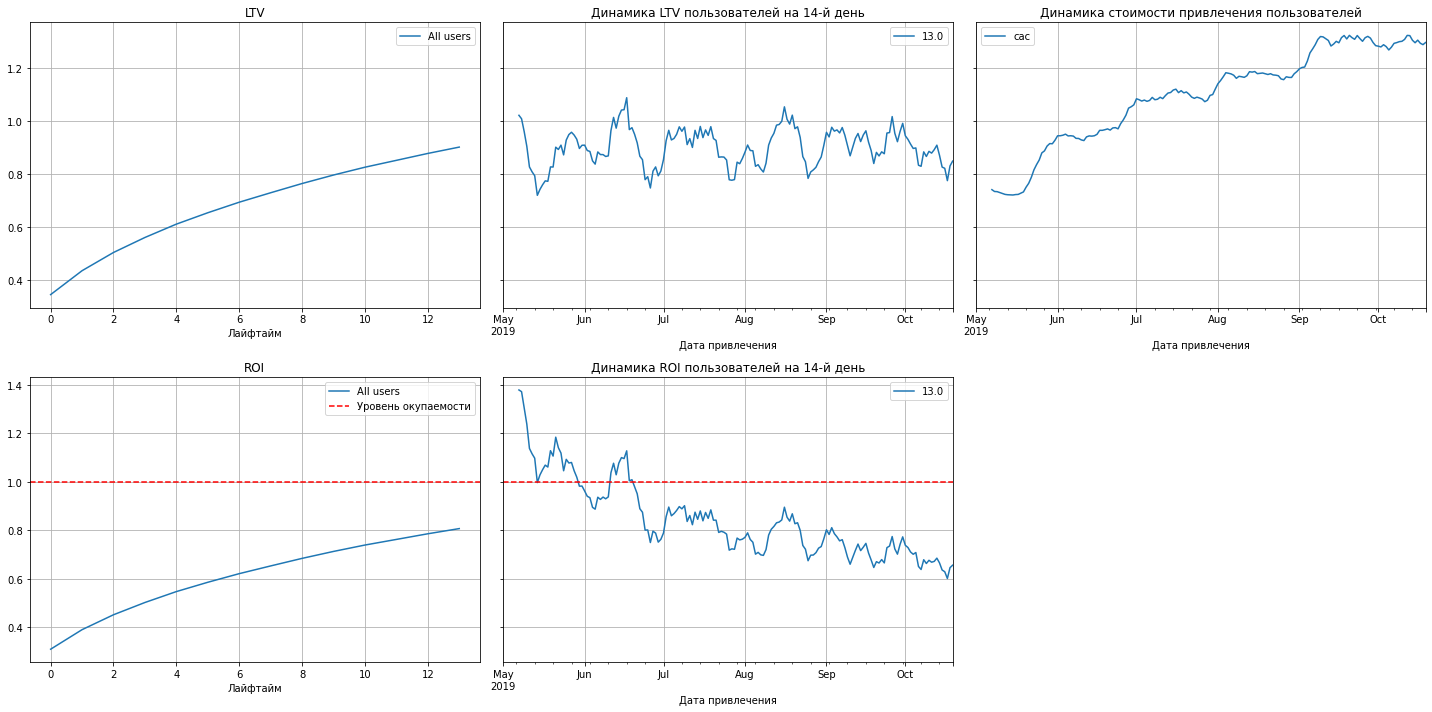

In [49]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days, window=7)

Реклама не окупается ROI к концу второй недели достигает лишь 80 %. CAC увеличивается на всем изучаемом периоде времени, это говорит об увеличении рекламного бюджета. Динамика LTV имеет сезонный характер, но все же стабильна - нет ухудшения качества пользователей.

Конверсия:

In [50]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(prof_without_org, orders, observation_date, horizon_days)

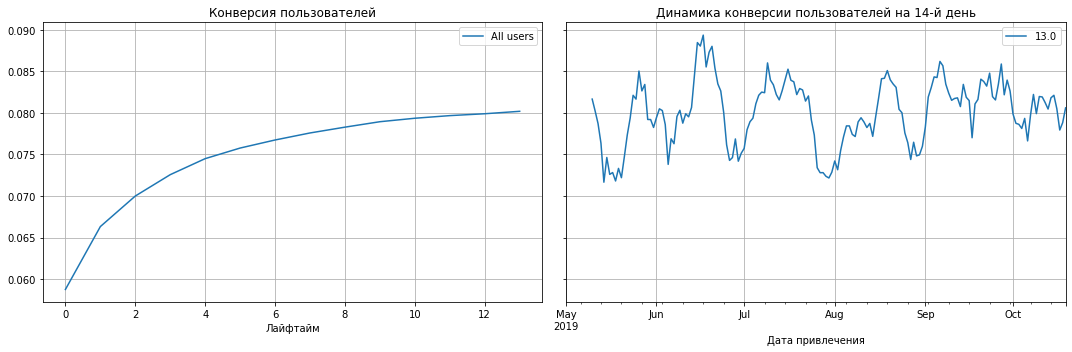

In [51]:
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=10)

Конверсия плользователей плавно растет и является стабильной.

Удержание:

In [52]:
retention_raw, retention_grouped, retention_history = get_retention(prof_without_org, visits, observation_date, horizon_days)

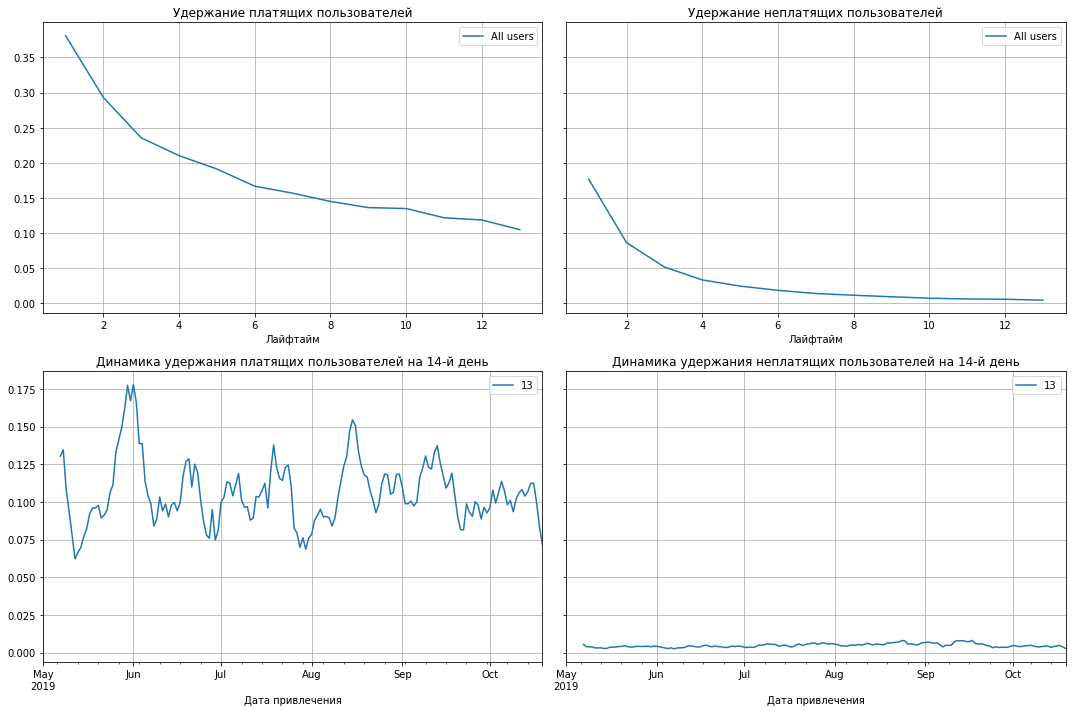

In [53]:
plot_retention(retention_grouped, retention_history, horizon_days, window=7)

Кривая удержания убывет по экспоненциальному закону. Кривая удержания платящих пользователей стабильна. У неплатящих пользователей удержание на очень низком уровне.

Удержание неплатящих пользователей выходит на плато примерно с 9го дня.

**Окупаемость рекламы с разбивкой по устройствам:**

In [54]:
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(prof_without_org, orders, observation_date, horizon_days, dimensions)

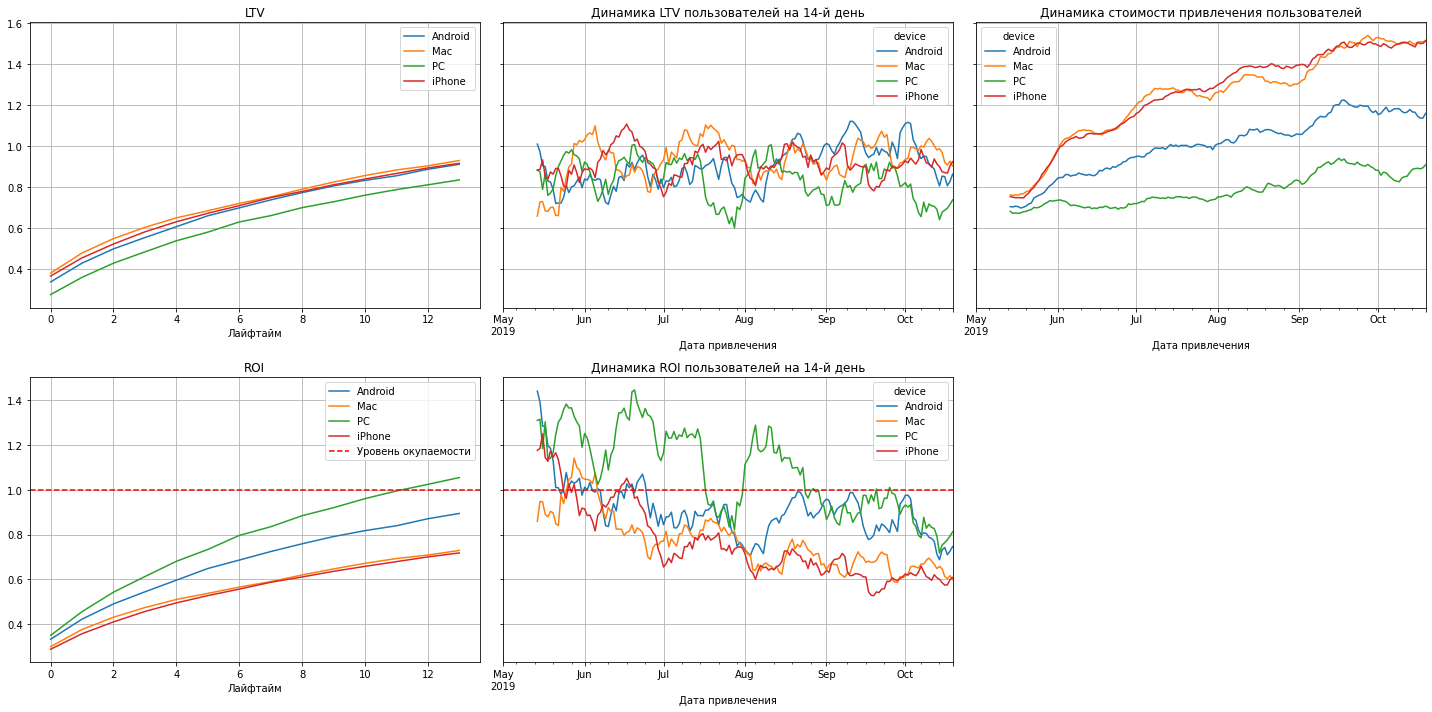

In [55]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days, window=14)

 Окупаются только пользователи PC на 11-ый день. LTV стабилен, худший LTV у PC. Не окупаются пользователи Android, iPhone и Mac. Стоимость привлечения пользователей плавно возрастает для пользователей Mac и iPhone. У PC примерно стабильно.

Динамика ROI на 14ый день снижается по всем устройствам. С конца августа нет окупаемости ни по одному устройству.

**Окупаемость рекламы с разбивкой по странам:**

In [56]:
dimensions = ['region']
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(prof_without_org, orders, observation_date, horizon_days, dimensions)

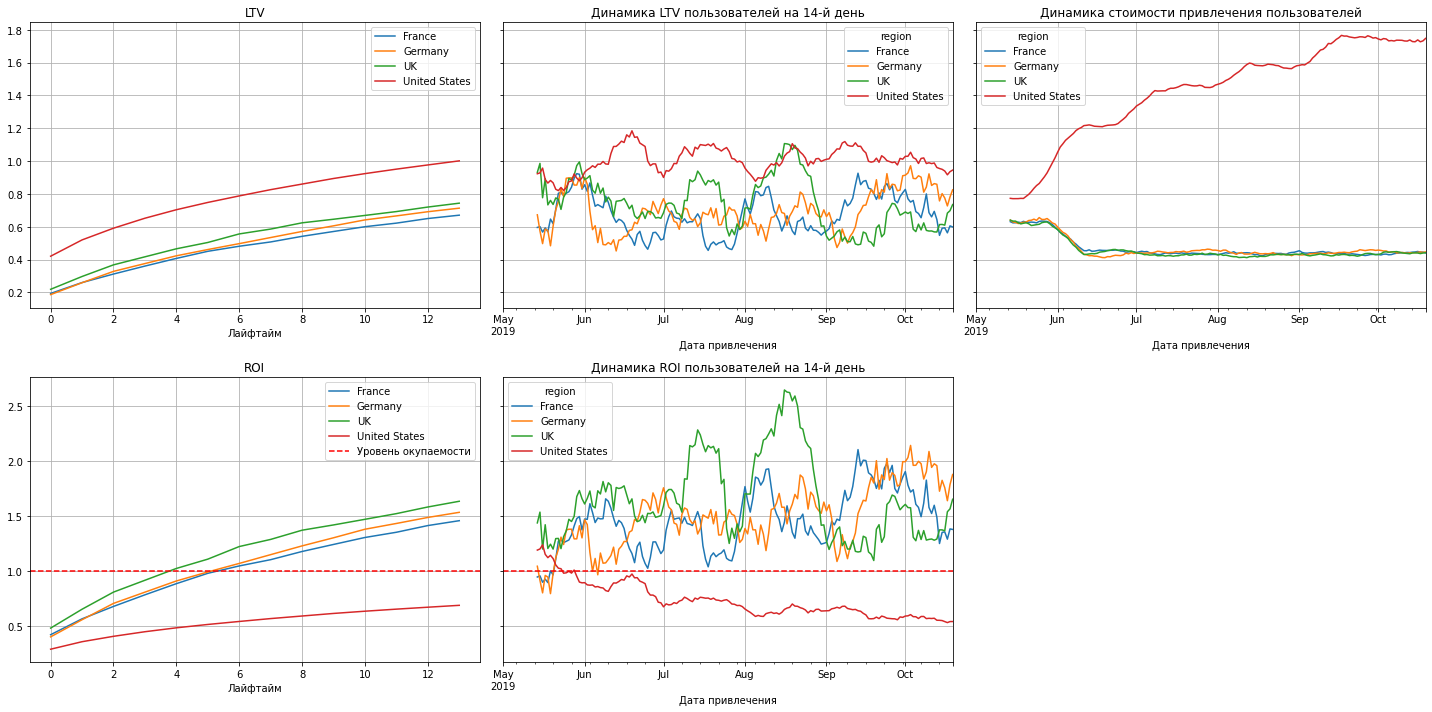

In [57]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days, window=14)

Сразу видно, что реклама не окупается в США. Стоимость привлечения пользователей из США сильно выше остальных стран, она увеличивается на всем изучаемом периоде времени. Напротив, стоимость привлечения пользователей у других стран сначала немного падает, затем остается на одном уровне. LTV стабилен, выше всего у США. Выше всего окупаемость пользователей из Великобритании.

На графике с динамикой ROI заметны всплески у Великобритании. Пиковые значения приходятся на середину июля и середину августа.

**Окупаемость рекламы с разбивкой по рекламным каналам:**

In [58]:
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(prof_without_org, orders, observation_date, horizon_days, dimensions)

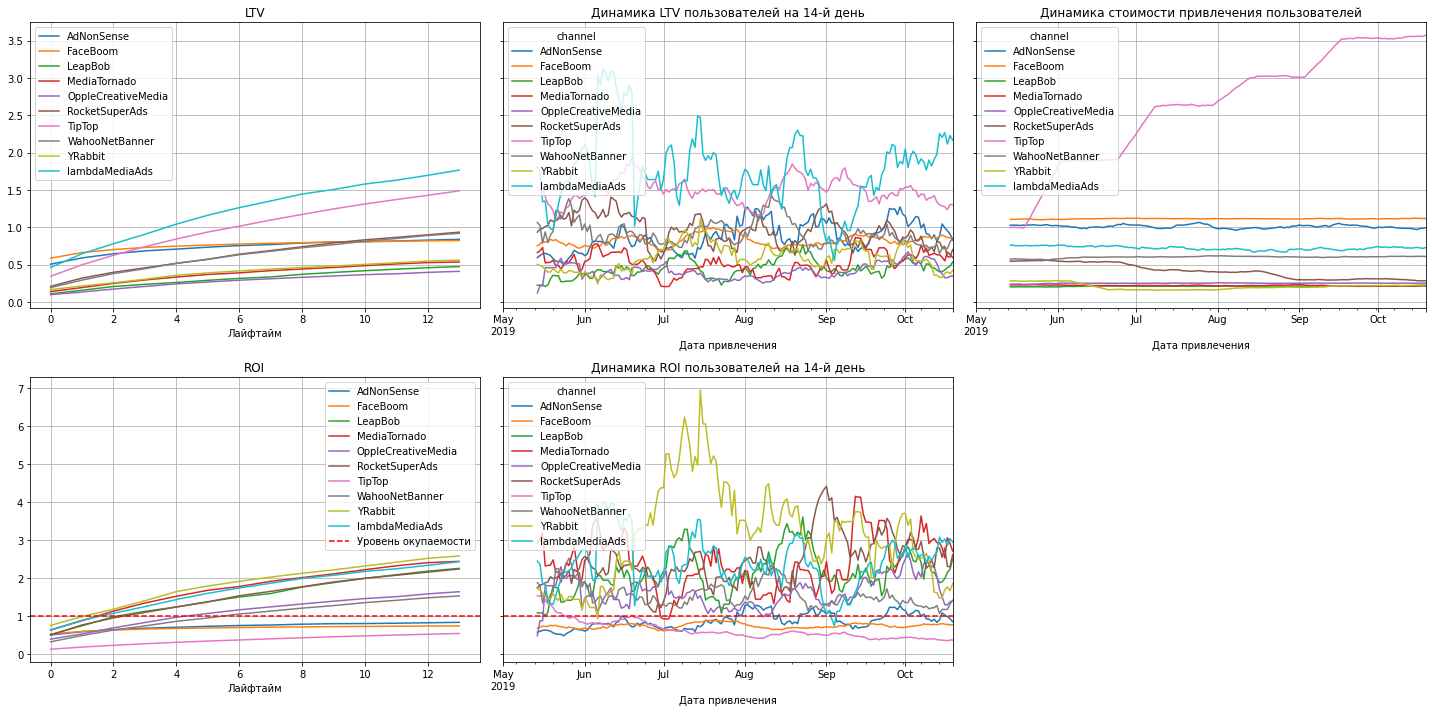

In [59]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days, window=14)

Убыточными являются следующие источники привлечения пользователей "TipTop", "FaceBoom" и "AdNonSense". Источники "WahooNetBanner" и "OppleCreativeMedia" начинают окупаться с 5го дня, а все остальные источники, начиная со 2го. Наибольший показатель ROI у источника "YRabbit". Стоимсоть привлечения пользоателей у источника "TipTop" заметно растет ступенчато от месяца к месяцу. Стоимоть привлечения пользователей из источника "RocketSuperAds" плавно снижается. Показатели САС остальных источников стабильны, но находятся на разных уровнях. Показатели LTV стабильны, но существенно различаются между собой. Лучший показатель LTV у источника "lambdaMediaAds".

На графике с динамикой ROI можно заметить необычный всплеск по рекламному источнику "YRabbit". Пиковое значение приходится на середину июля. Пользователи из данного канала из США.

Также, посмотрим на конверсию и удержание с разбивкой по устройствам, странам и рекламным каналам.

**Графики конверсии и удержания с разбивкой по устройствам:**

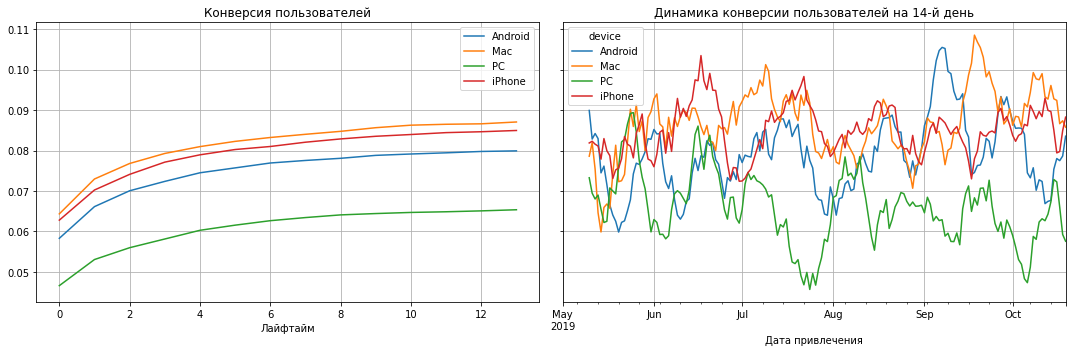

In [60]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(prof_without_org, orders, observation_date, horizon_days, dimensions=dimensions)
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=10)

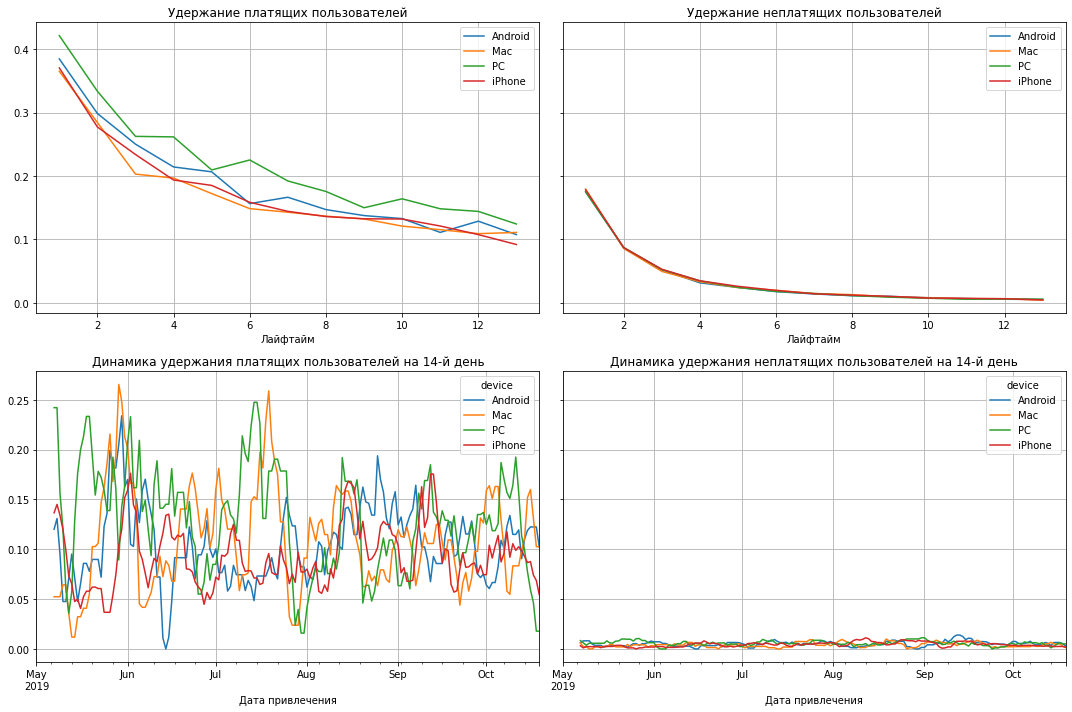

In [61]:
retention_raw, retention_grouped, retention_history = get_retention(prof_without_org, visits, observation_date, horizon_days, dimensions=dimensions)
plot_retention(retention_grouped, retention_history, horizon_days) 

Лучше всего конвертируются пользователи с Mac и iPhone, пользователи PC конвертируются заметно хуже. Удержание неплатящих пользователей на очень низком уровне для пользователей всех устройств. Удержание платящих пользователей всех устройств примерно на одном уровне (у пользователей PC чуть выше остальных).

**Графики конверсии и удержания с разбивкой по странам:**

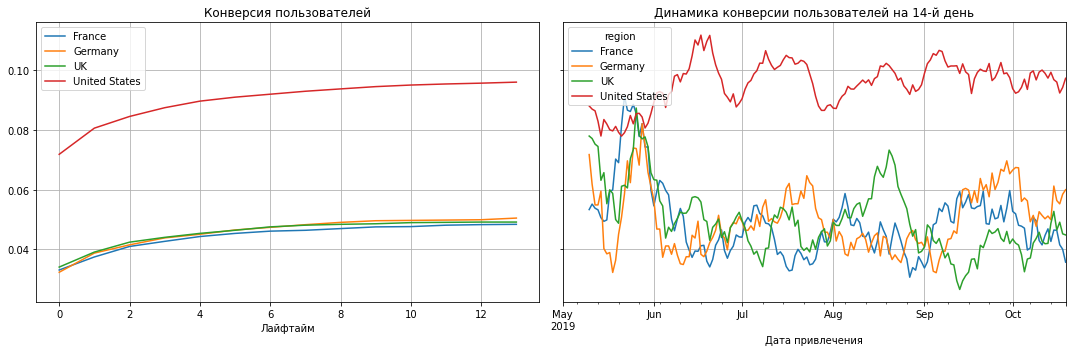

In [62]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(prof_without_org, orders, observation_date, horizon_days, dimensions=dimensions)
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=10)

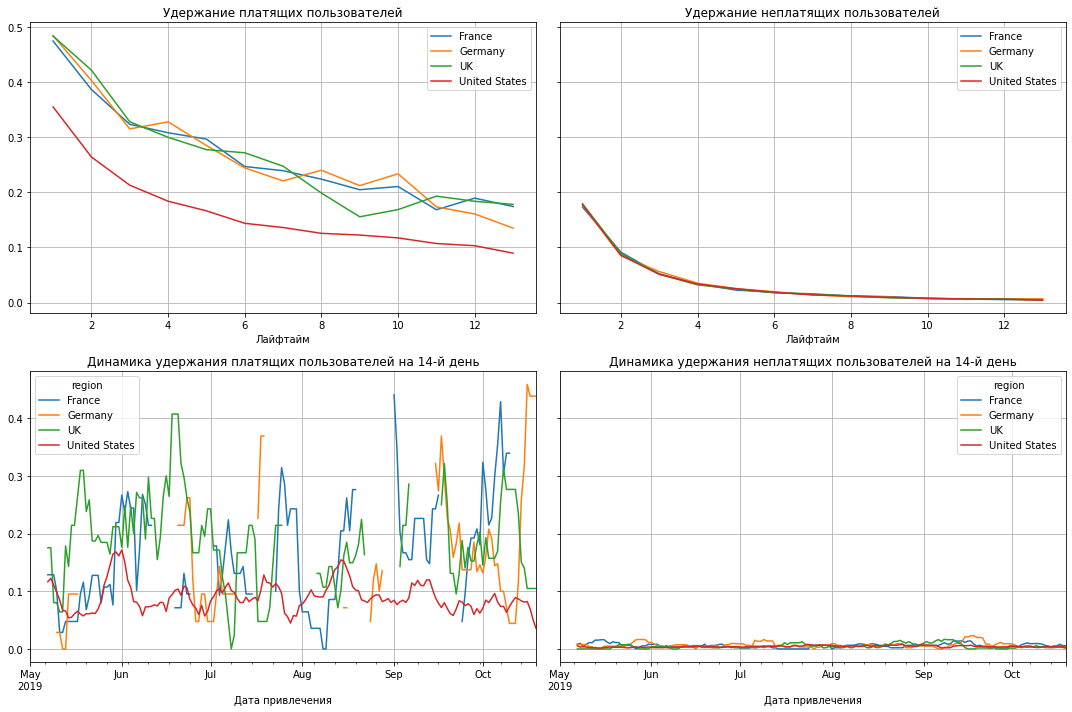

In [63]:
retention_raw, retention_grouped, retention_history = get_retention(prof_without_org, visits, observation_date, horizon_days, dimensions=dimensions)
plot_retention(retention_grouped, retention_history, horizon_days) 

Показатель конверсии у пользователей США существенно выше, чем у других стран. Однако, показатель удержания у США самый низкий.

**Графики конверсии и удержания с разбивкой по рекламным источникам:**

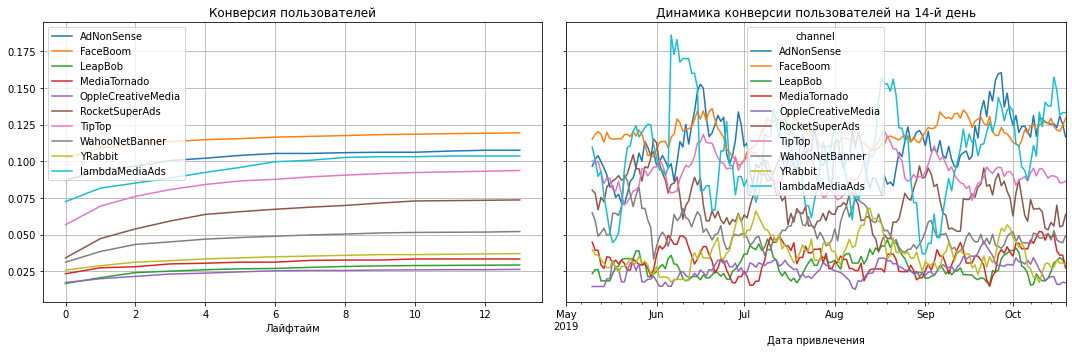

In [64]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(prof_without_org, orders, observation_date, horizon_days, dimensions=dimensions)
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=10)

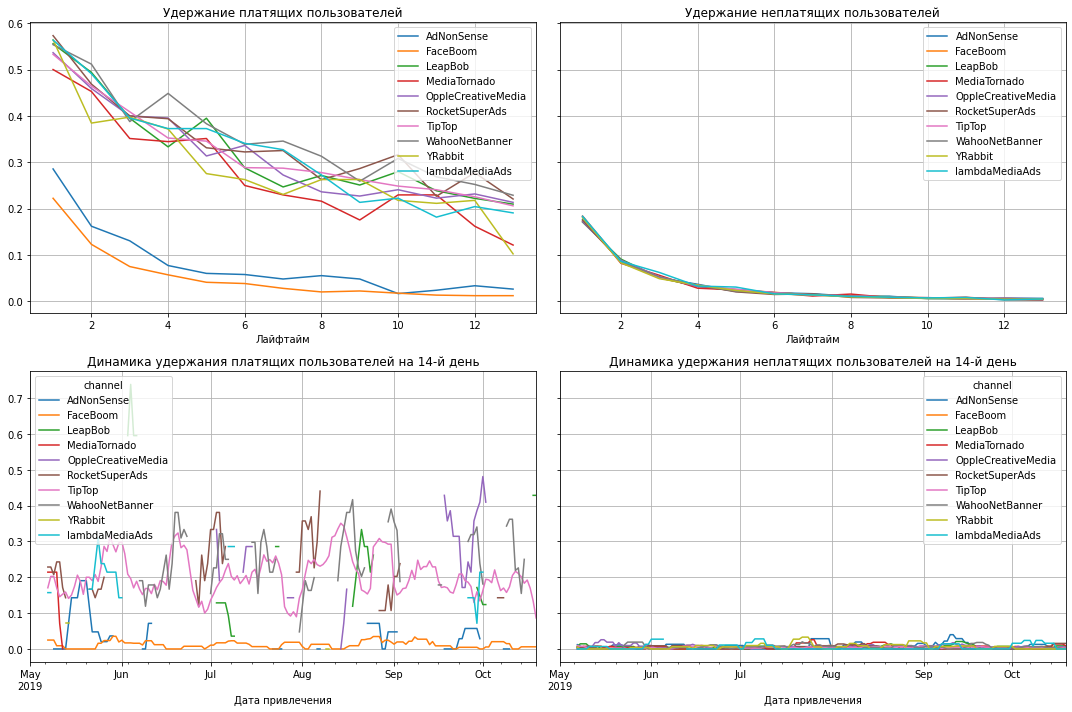

In [65]:
retention_raw, retention_grouped, retention_history = get_retention(prof_without_org, visits, observation_date, horizon_days, dimensions=dimensions)
plot_retention(retention_grouped, retention_history, horizon_days) 

Пользователи всех рекламных источников конверитруются по-разному. Наивысший показатель конверсии у пользователей из источников "FaceBoom", "AdNonSense" и "lambdaMediaAds". Ниже всего конверсия у пользователей из источника "OppleCreativeMedia". Также видно, что самый низкий показатель удержания у источников "FaceBoom" и "AdNonSense".

Также, выяснили, что все пользователи, привлеченные из каналов "TipTop" и "FaceBoom" из США:

In [66]:
profiles_t_f = profiles.query('channel == "FaceBoom" or channel == "TipTop"')
profiles_t_f['region'].unique()

array(['United States'], dtype=object)

Попробуем исключить пользователей из источников "TipTop" и "FaceBoom" и построить графики:

In [67]:
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(prof_without_org.query('channel != "TipTop" and channel !="FaceBoom"'), orders, observation_date, horizon_days)

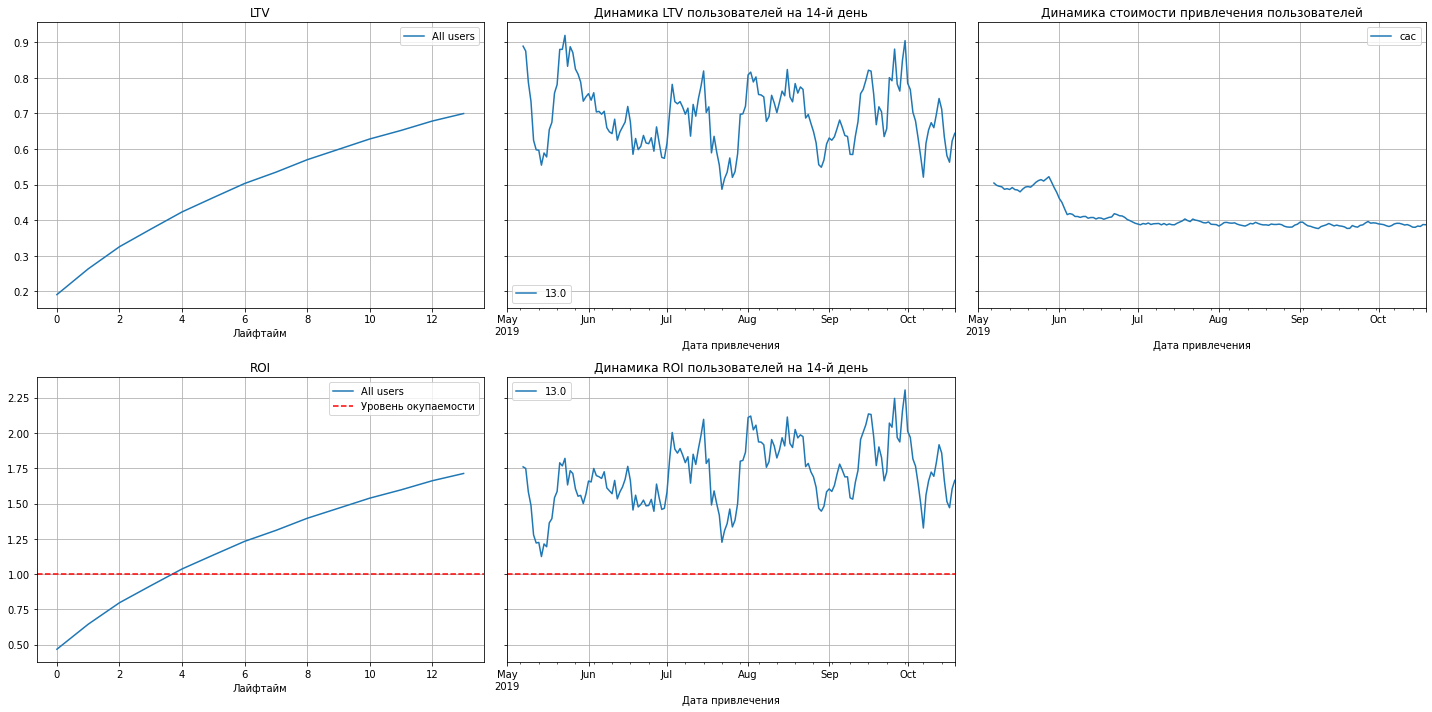

In [68]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days, window=7)

Реклама окупается уже на 4ый день!

**Анализ окупаемости рекламы с разбивкой по рекламным каналам для США и Европейских стран**

*США:*

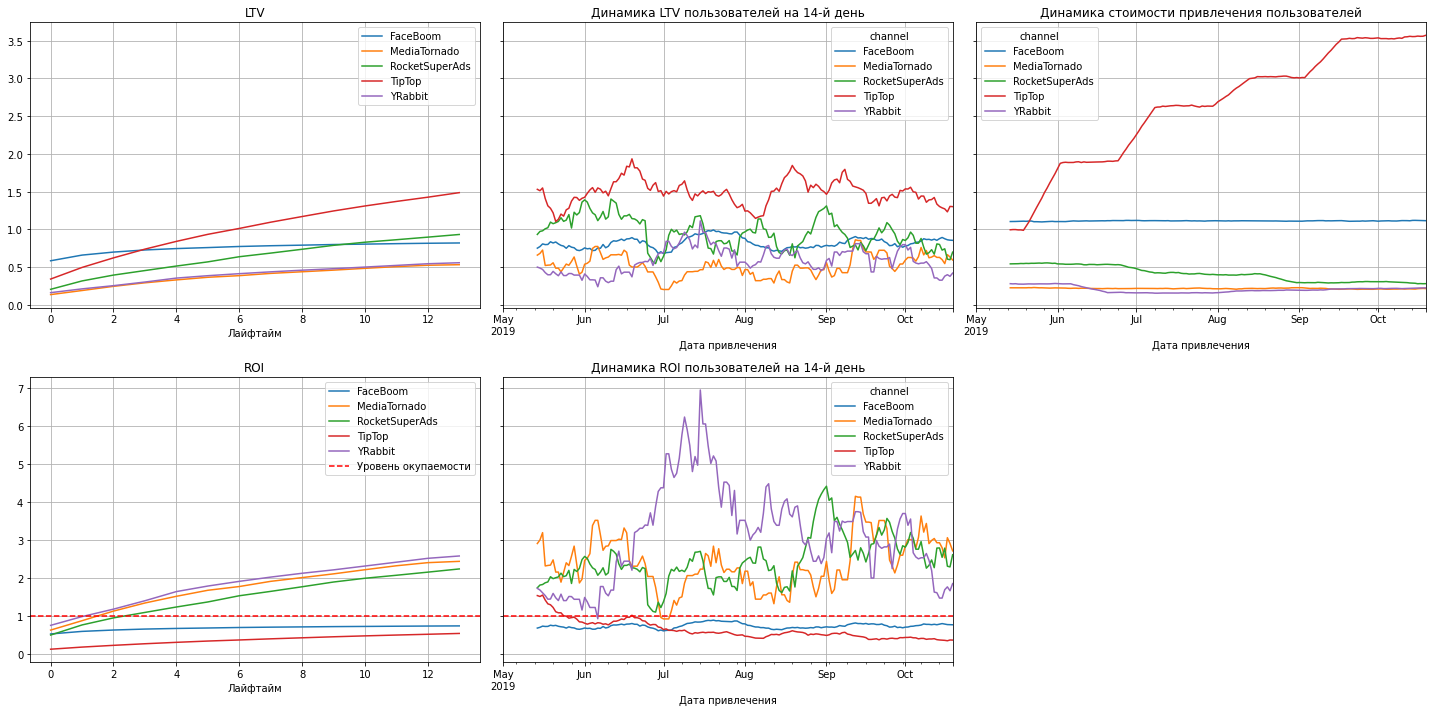

In [69]:
profiles_USA = profiles.query('region == "United States" and channel != "organic"')
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(profiles_USA, orders, observation_date, horizon_days, dimensions)
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days, window=14)

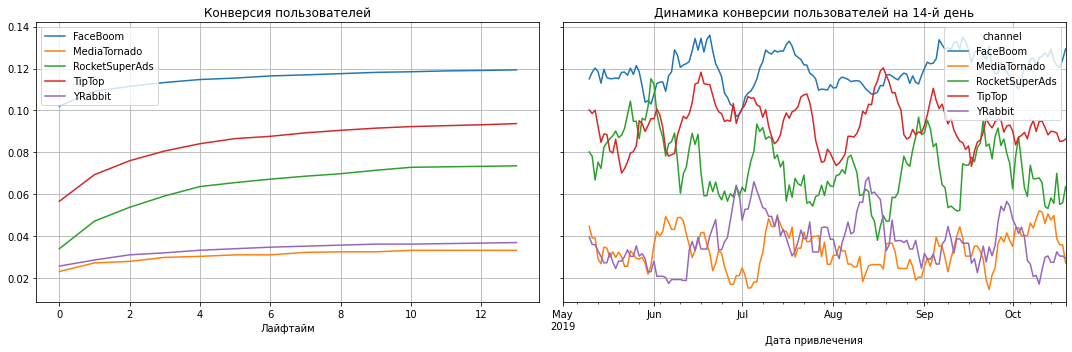

In [70]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles_USA, orders, observation_date, horizon_days, dimensions=dimensions)
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=10)

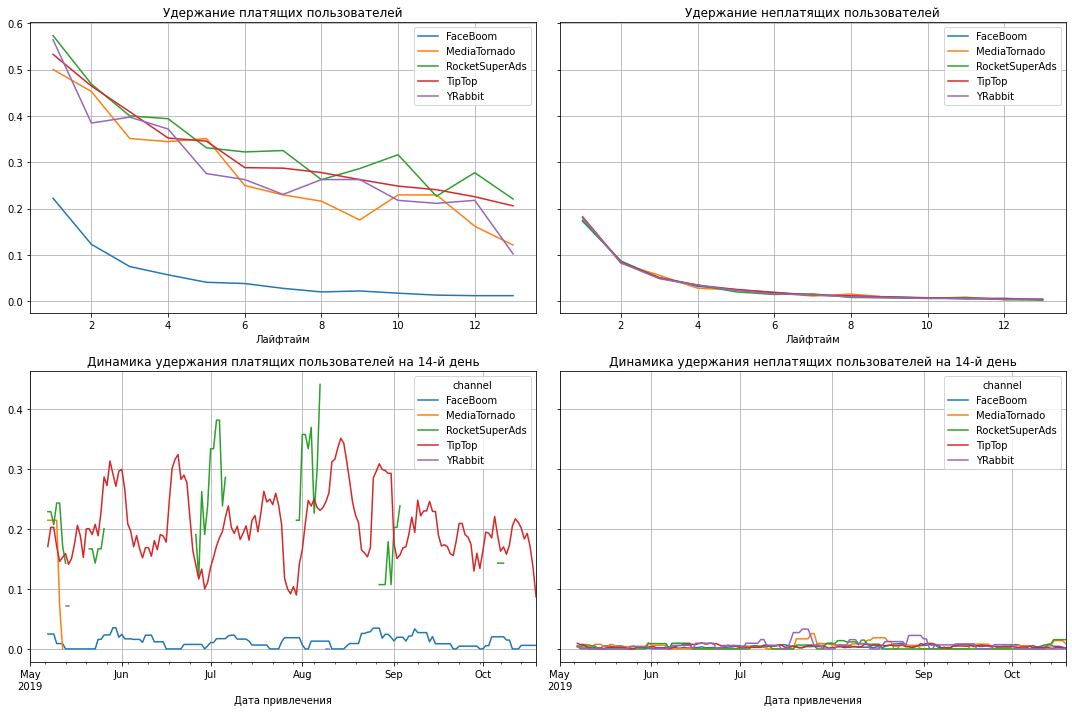

In [71]:
retention_raw, retention_grouped, retention_history = get_retention(profiles_USA, visits, observation_date, horizon_days, dimensions=dimensions)
plot_retention(retention_grouped, retention_history, horizon_days)

Наилучший показатель LTV показывает источник "TipTop". Показатель LTV у "FaceBoom" тоже неплохой, но он почти не изменяется на протяжении исследуемого периода. Хороший показатель LTV показывает источник "RocketSuperAds". У остальных источников показаетль LTV примерно на одном уровне. Как говорилось раньше, стоимость привлеяения пользователей из источника "TipTop" сильно растет. У источника "FaceBoom" динамика стоимости привлечения пользователей не меняется, но она изначально, на высоком уровне. По графику также видно, что у источника "RocketSuperAds" стоимость привлечения пользователей постепенно снижалась до определенного уровня. Не оупилось два источника "TipTop" и "FaceBoom". Если не учитывать убыточные источники привлечения "TipTop" и "FaceBoom", то неплохая конверсия наблюдается у пользователей из источника "RocketSuperAds". Удержание по всем каналам примерно одинаково, кроме "FaceBoom"- у него удержание самое низкое. Рекламный бюджет в США стоит перенаправить на источник привлечения пользователей "RocketSuperAds" вследствие его хорошего показателя LTV, его окупаемости и конверсии. Также неплохой показатель окупаемости у "YRabbit".

*Европейские страны:*

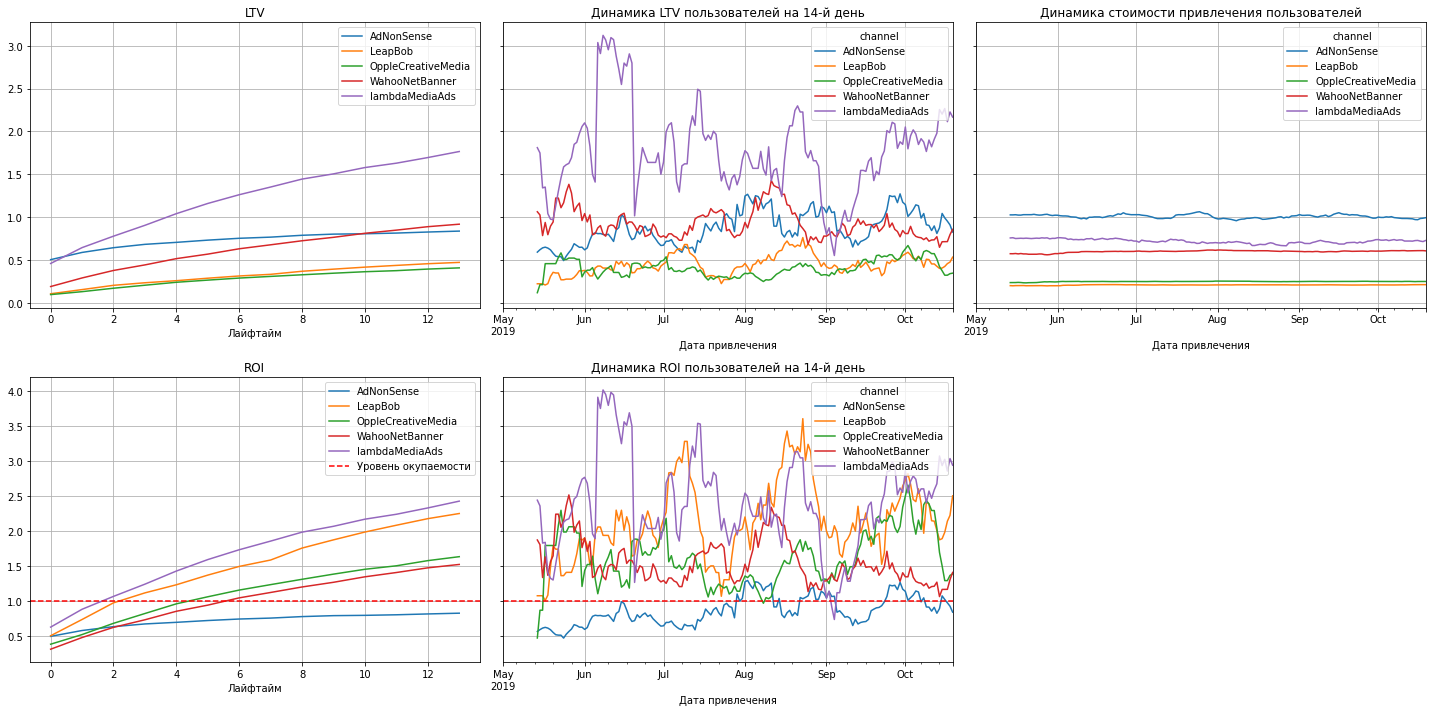

In [72]:
profiles_europe = prof_without_org.query('region == "France" or region == "Germany" or region == "UK"')
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(profiles_europe, orders, observation_date, horizon_days, dimensions)
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days, window=14)

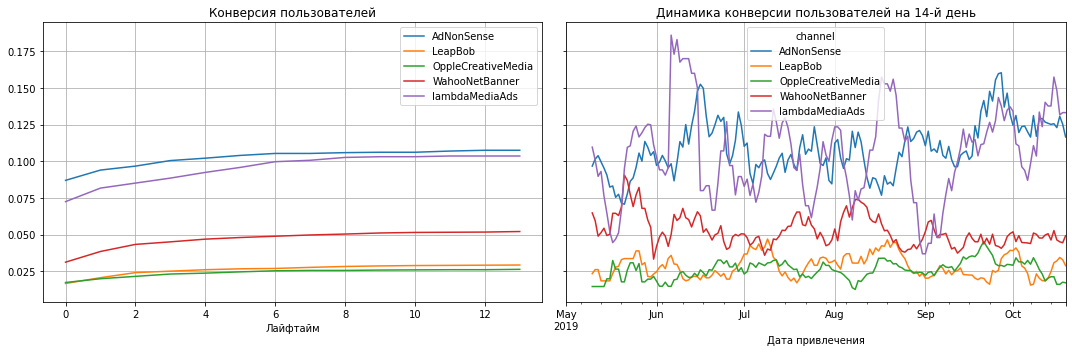

In [73]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles_europe, orders, observation_date, horizon_days, dimensions=dimensions)
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=10)

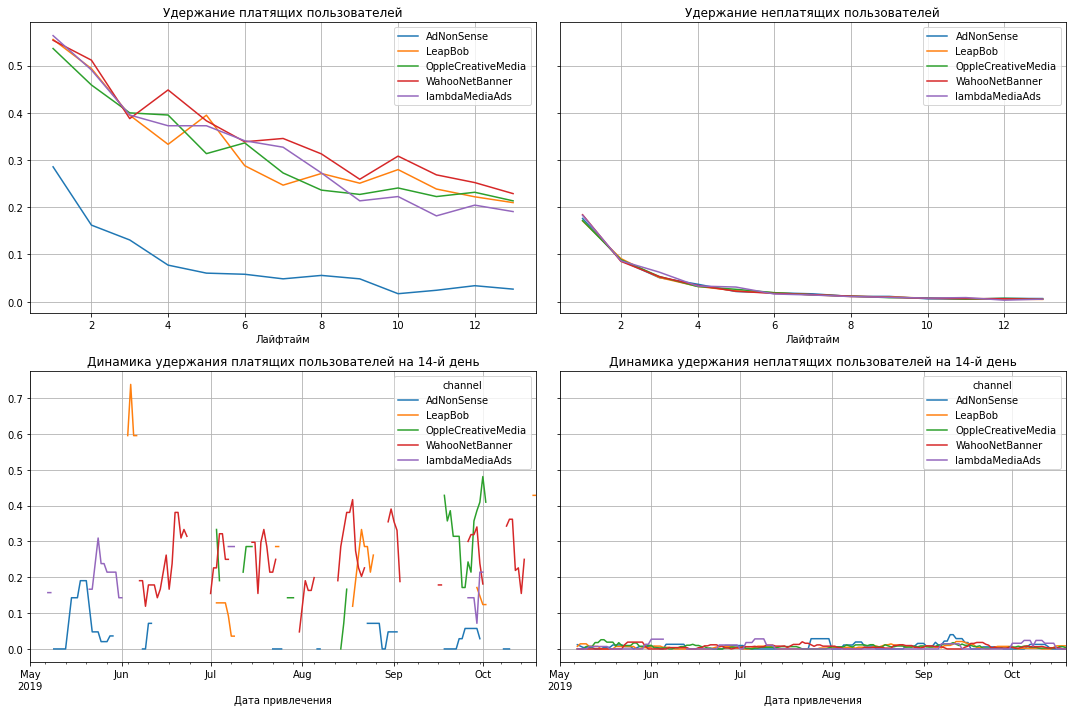

In [74]:
retention_raw, retention_grouped, retention_history = get_retention(profiles_europe, visits, observation_date, horizon_days, dimensions=dimensions)
plot_retention(retention_grouped, retention_history, horizon_days)

Лучший показатель LTV у источника "LambdaMediaAds". Показатель LTV у "AdNonSense" тоже неплохой, но он почти не изменяется на протяжении исследуемого периода. Хороший показатель LTV показывает источник "WahooNetBanner". У остальных источников показаетль LTV примерно на одном уровне. Динамика стоимости привлечения пользователей по всем каналам не менялась, но все они на разном уровне. Выше всего стоимость у канала "AdNonSense", далее идет канал "LambdaMediaAds" и "WahooNetBanner". За весь период не окупается только канал "AdNonSense". Наилучшая окупаемость у каналов "LambdaMediaAds" и "LeapBob". Лучшая конверсия у каналов "AdNonSense" и "LambdaMediaAds". Чуть ниже конверсия "WahooNetBanner". Худший показатель удержания у "AdNonSense". Наилудший показатель удержания у "WahooNetBanner". Источник "AdNonSense" является убыточным, несмотря на высокую стоимость привлеяения пользователей и хорошуй конверсию пользователей. Стоит перераспределить рекламный бюджет в Европейских странах на канал "LambdaMediaAds" он хорош по всем показателям. Также, стоит присмотерться к "WahooNetBanner" (неплохая конверсия и показатель удержанаия).

 - Исходя из полученных графиков, можно сделать вывод, что реклама, направленная на привлечение пользователей в целом не окупается за весь исследуемый период.
 - Совсем не окупается реклама для привлечения пользователей: из США (пользователи из США хорошо конвертируются, но показатель удержания самый низкий), использующих Android, Mac и iPhone, привлеченных из источников "TipTop", "FaceBoom" и "AdNonSense".
 - Неоправданно много средств было вложено в рекламные источники, которые в итоге не окупились ("TipTop" и "FaceBoom"). Нужно либо снизить финансирование данных источников, либо отказаться от них совсем и сместить фокус на более перспективные (например, "Lambda_Media_Ads"). Также, стоит рассмотреть тот факт, что существуют технические проблемы в источниках "TipTop" и "FaceBoom". Если это так, то необходимо заняться их устранением.

# Общий вывод

 - Загрузили данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- В ходе предобработки данных привели названия всех столбцов к нижнему регистру, сделали проверку на наличие явных дубликатов - явных дубликатов не обнаружено, привели все столбцы с датами к кореектному типу datetime, пропусков во всех фреймах данных не обнаружено.
 -  Составили профили пользователей, привлеченных с 1 мая 2019 года по 27 октября 2019 года, провели исследовательский анализ:
- Приложение используют в четырех странах: США, Германия, Великобритания и Франция. Наибольшее количество пользователей из США, среди платящих пользователей также наибольший процент из США (6.9%);
- Пользователи приложения используют следующие устройства: Mac, iPhone, Android, PC. Наибольшее количество пользователей использует iPhone, наибольший процент платящих пользователей использует Mac (6.36%);
- Наибольшее количество пользователей привлечено из "органических" источников, "FaceBoom" и "TipTop", Наибольший процент платящих пользователей привлечен из "FaceBoom" (12.2%), "AdNonSense" (11.34%) и "lambdaMediaAds" (10.47%).
 -  Провели маркетинговый анализ:
- Общая сумма расходов на маркетинг составила 105497.
- Наибольшие траты на рекламу приходятся на источник "TipTop" и "FaceBoom". Данные источники составляют больше 80% от всех расходов на рекламу и являются самыми дорогими. Меньше всего расходов приходится на источники "MediaTornado" и "YRabbit".
- Изучив динамику изменения расходов на рекламу, можно сделать вывод, что существенные изменения расходов на рекламу у источника "TipTop". Наблюдается ступенчатый рост расходов по этому источнику. Также, у источника "FaceBoom" наблюдается небольшой рост расходов на рекламу.
- Наиболее дорогой источник привлечения пользователя "TipTop", по стоимости он сильно превосходит все остальные источники. Самым недорогим источником привлечения пользователя является "LeapBob".
- В среденем, по всем каналам, на привлечение одного пользователя тратится 0.7.
 - Провели оценку окупаемость рекламы:
- реклама не окупается ROI к концу второй недели достигает лишь 80 %. CAC увеличивается на всем изучаемом периоде времени, это говорит об увеличении рекламного бюджета. Динамика LTV имеет сезонный характер, но все же стабильна - нет ухудшения качества пользователей.
- Окупаются только пользователи PC на 11-ый день. Не окупаются пользователи Android, iPhone и Mac. Стоимость привлечения пользователей плавно возрастает для пользователей Mac и iPhone.
- Реклама не окупается в США. Стоимость привлечения пользователей из США сильно выше остальных стран, она увеличивается на всем изучаемом периоде времени. Напротив, стоимость привлечения пользователей у других стран сначала немного падает, затем остается на одном уровне. LTV стабилен, выше всего у США. Выше всего окупаемость пользователей из Великобритании.
- Убыточными являются следующие источники привлечения пользователей "TipTop", "FaceBoom" и "AdNonSense". Источники "WahooNetBanner" и "OppleCreativeMedia" начинают окупаться с 5го дня, а все остальные источники, начиная со 2го. Наибольший показатель ROI у источника "YRabbit". Стоимсоть привлечения пользоателей у источника "TipTop" заметно растет ступенчато от месяца к месяцу. Стоимоть привлечения пользователей из источника "RocketSuperAds" плавно снижается. Показатели САС остальных источников стабильны, но находятся на разных уровнях. Показатели LTV стабильны, но существенно различаются между собой. Лучший показатель LTV у источника "lambdaMediaAds".
- Неоправданно много средств было вложено в рекламные источники, которые в итоге не окупились ("TipTop" и "FaceBoom"). Нужно либо снизить финансирование данных источников, либо отказаться от них совсем и сместить фокус на более перспективные (например, "Lambda_Media_Ads"). Также, стоит рассмотреть тот факт, что существуют технические проблемы в источниках "TipTop" и "FaceBoom". Если это так, то необходимо заняться их устранением.
- Источник "FaceBoom" не окупался за весь период изучения, несмторя на хорошую конверсию имеет худший коэффициент удержания. Также, имеет высокую стоимость привлечения пользователей, показатель LTV за весь период не меняется.
-  Рекламный бюджет в США стоит перенаправить на источник привлечения пользователей "RocketSuperAds" вследствие его хорошего показателя LTV, его окупаемости и хорошей конверсии.
- Стоит перераспределить рекламный бюджет в Европейских странах на канал "LambdaMediaAds" он хорош по всем показателям (отличный показатель LTV, хорошая окупаемость и высокая конверсия пользователей).